In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
% cd /content/drive/MyDrive/MIPT/ocr/course_ocr/task1

In [ ]:
! pip install -e .
! pip install wandb
! pip install pytorch-lightning
! pip install opencv-python
! pip install opencv-contrib-python

In [5]:
from course_ocr_t1.data import MidvPackage
from course_ocr_t1.metrics import iou_relative_quads, dump_results_dict, measure_crop_accuracy

import os
import yaml
import json
import math
import subprocess
from subprocess import TimeoutExpired
from collections import OrderedDict
from time import time
from pathlib import Path

import cv2
import imutils
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from itertools import product

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset

import torchvision
import torchvision.utils as vutils
from torchvision import transforms as VT

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
import pytorch_lightning as pl
import wandb
wandb.login()

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer

wandb: Currently logged in as: taya. Use `wandb login --relogin` to force relogin


## Data preparation

In [7]:
# ! unzip midv500_compressed.zip

DATASET_PATH = Path() / 'midv500_compressed'
assert DATASET_PATH.exists(), DATASET_PATH.absolute()

data_packs = MidvPackage.read_midv500_dataset(DATASET_PATH)
len(data_packs), type(data_packs[0])

(50, course_ocr_t1.data.MidvPackage)

In [8]:
class DetectionDataset(Dataset):
    def __init__(self, data_packs, is_test=False):
        self.data = []
        transform = VT.Compose([
            VT.Resize((160, 90), VT.InterpolationMode.BICUBIC),
            VT.ToTensor(),
        ])

        for i in tqdm(range(len(data_packs))):
            pack = data_packs[i]
            for j in tqdm(range(len(pack))):
                if pack[j].is_test_split() == is_test:
                    img = transform(pack[j].image)
                    c, h, w = img.shape

                    quad = np.array(pack[j].quadrangle * [w, h], dtype=np.int32)
                    mask = np.zeros((h, w), dtype=np.uint8)
                    cv2.fillPoly(mask, quad.reshape(-1, 4, 2), 1)
                    mask = torch.from_numpy(np.array(mask))

                    x_min = min(quad[:, 0])
                    x_max = max(quad[:, 0])
                    y_min = min(quad[:, 1])
                    y_max = max(quad[:, 1])
                    box = [x_min, y_min, x_max, y_max]
                    area = (box[2] - box[0]) * (box[3] - box[1])

                    target = {
                        'boxes': torch.as_tensor([box], dtype=torch.float32), 
                        'area': torch.as_tensor([area], dtype=torch.float32),
                        'masks': mask.unsqueeze(0),
                        'labels': torch.as_tensor([1], dtype=torch.int64),
                        'iscrowd': torch.as_tensor([0], dtype=torch.int64),
                        'image_id': torch.as_tensor([i * 300 + j])
                    }

                    if not is_test:
                        self.data.append((img, target))
                    else:
                        self.data.append((pack[j].unique_key, img, target, pack[j].quadrangle))

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

In [9]:
# train_dataset = DetectionDataset(data_packs)
# test_dataset = DetectionDataset(data_packs, True)

# torch.save(train_dataset, '/content/drive/MyDrive/MIPT/ocr/course_ocr/task1/train_dataset.pt')
# torch.save(test_dataset, '/content/drive/MyDrive/MIPT/ocr/course_ocr/task1/test_dataset.pt')

train_dataset = torch.load('/content/drive/MyDrive/MIPT/ocr/course_ocr/task1/train_dataset.pt')
test_dataset = torch.load('/content/drive/MyDrive/MIPT/ocr/course_ocr/task1/test_dataset.pt')

In [10]:
n = len(train_dataset)
train_data, val_data = random_split(train_dataset, [int(0.9 * n), n - int(0.9 * n)])

train_dataloader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_data, batch_size=4, shuffle=True, num_workers=0)

## Model

In [11]:
def get_iou(bb1, bb2):
    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_bottom = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_top = min(bb1[3], bb2[3])

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_top - y_bottom)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    return iou

In [17]:
class Detector(pl.LightningModule):
    def __init__(self, num_classes=2, hidden_layer = 256):
        super().__init__()
        self.save_hyperparameters()

        self.model = maskrcnn_resnet50_fpn(pretrained=True)
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        in_features_mask = self.model.roi_heads.mask_predictor.conv5_mask.in_channels
        self.model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    def forward(self, x, *args, **kwargs):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        torch.cuda.empty_cache() 
        imgs, targets = batch 
        targets = [dict(zip(targets, v)) for v in zip(*targets.values())]
        loss_dict = self.model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())
        self.log('loss_classifier', loss_dict['loss_classifier'].item(), on_step=True, on_epoch=True)
        self.log('loss_box_reg', loss_dict['loss_box_reg'].item(), on_step=True, on_epoch=True)
        self.log('loss_mask', loss_dict['loss_mask'].item(), on_step=True, on_epoch=True)
        self.log('loss_objectness', loss_dict['loss_objectness'].item(), on_step=True, on_epoch=True)
        self.log('loss_rpn_box_reg', loss_dict['loss_rpn_box_reg'].item(), on_step=True, on_epoch=True)
        self.log('loss', losses, on_step=True, on_epoch=True)
        return losses

    def validation_step(self, batch, batch_idx):
        torch.cuda.empty_cache() 
        images, targets = batch
        b, c, h, w = images.shape
        targets = [dict(zip(targets, v)) for v in zip(*targets.values())]
        outputs = self.model(images, targets)
        iou = 0
        for i in range(b):
            target_box = targets[i]['boxes'][0].detach().cpu().numpy()
            if len(outputs[i]['boxes'] > 0):
                out_box = outputs[i]['boxes'][0].detach().cpu().numpy()
                iou += get_iou(target_box, out_box)
        iou /= b
        self.log('iou', iou, on_step=True, on_epoch=True)
        return iou

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=3, gamma=0.1)
        lr_scheduler = {"scheduler": self.scheduler, "interval": "step"}
        return {
            "optimizer": self.optimizer,
            "lr_scheduler": lr_scheduler
        }

In [ ]:
detector = Detector()

wandb.finish()
wandb_logger = WandbLogger(project="OCR_1")
# max_time="00:01:00:00", 
trainer = Trainer(max_epochs=3, accelerator="gpu", logger=wandb_logger)
trainer.fit(model=detector, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

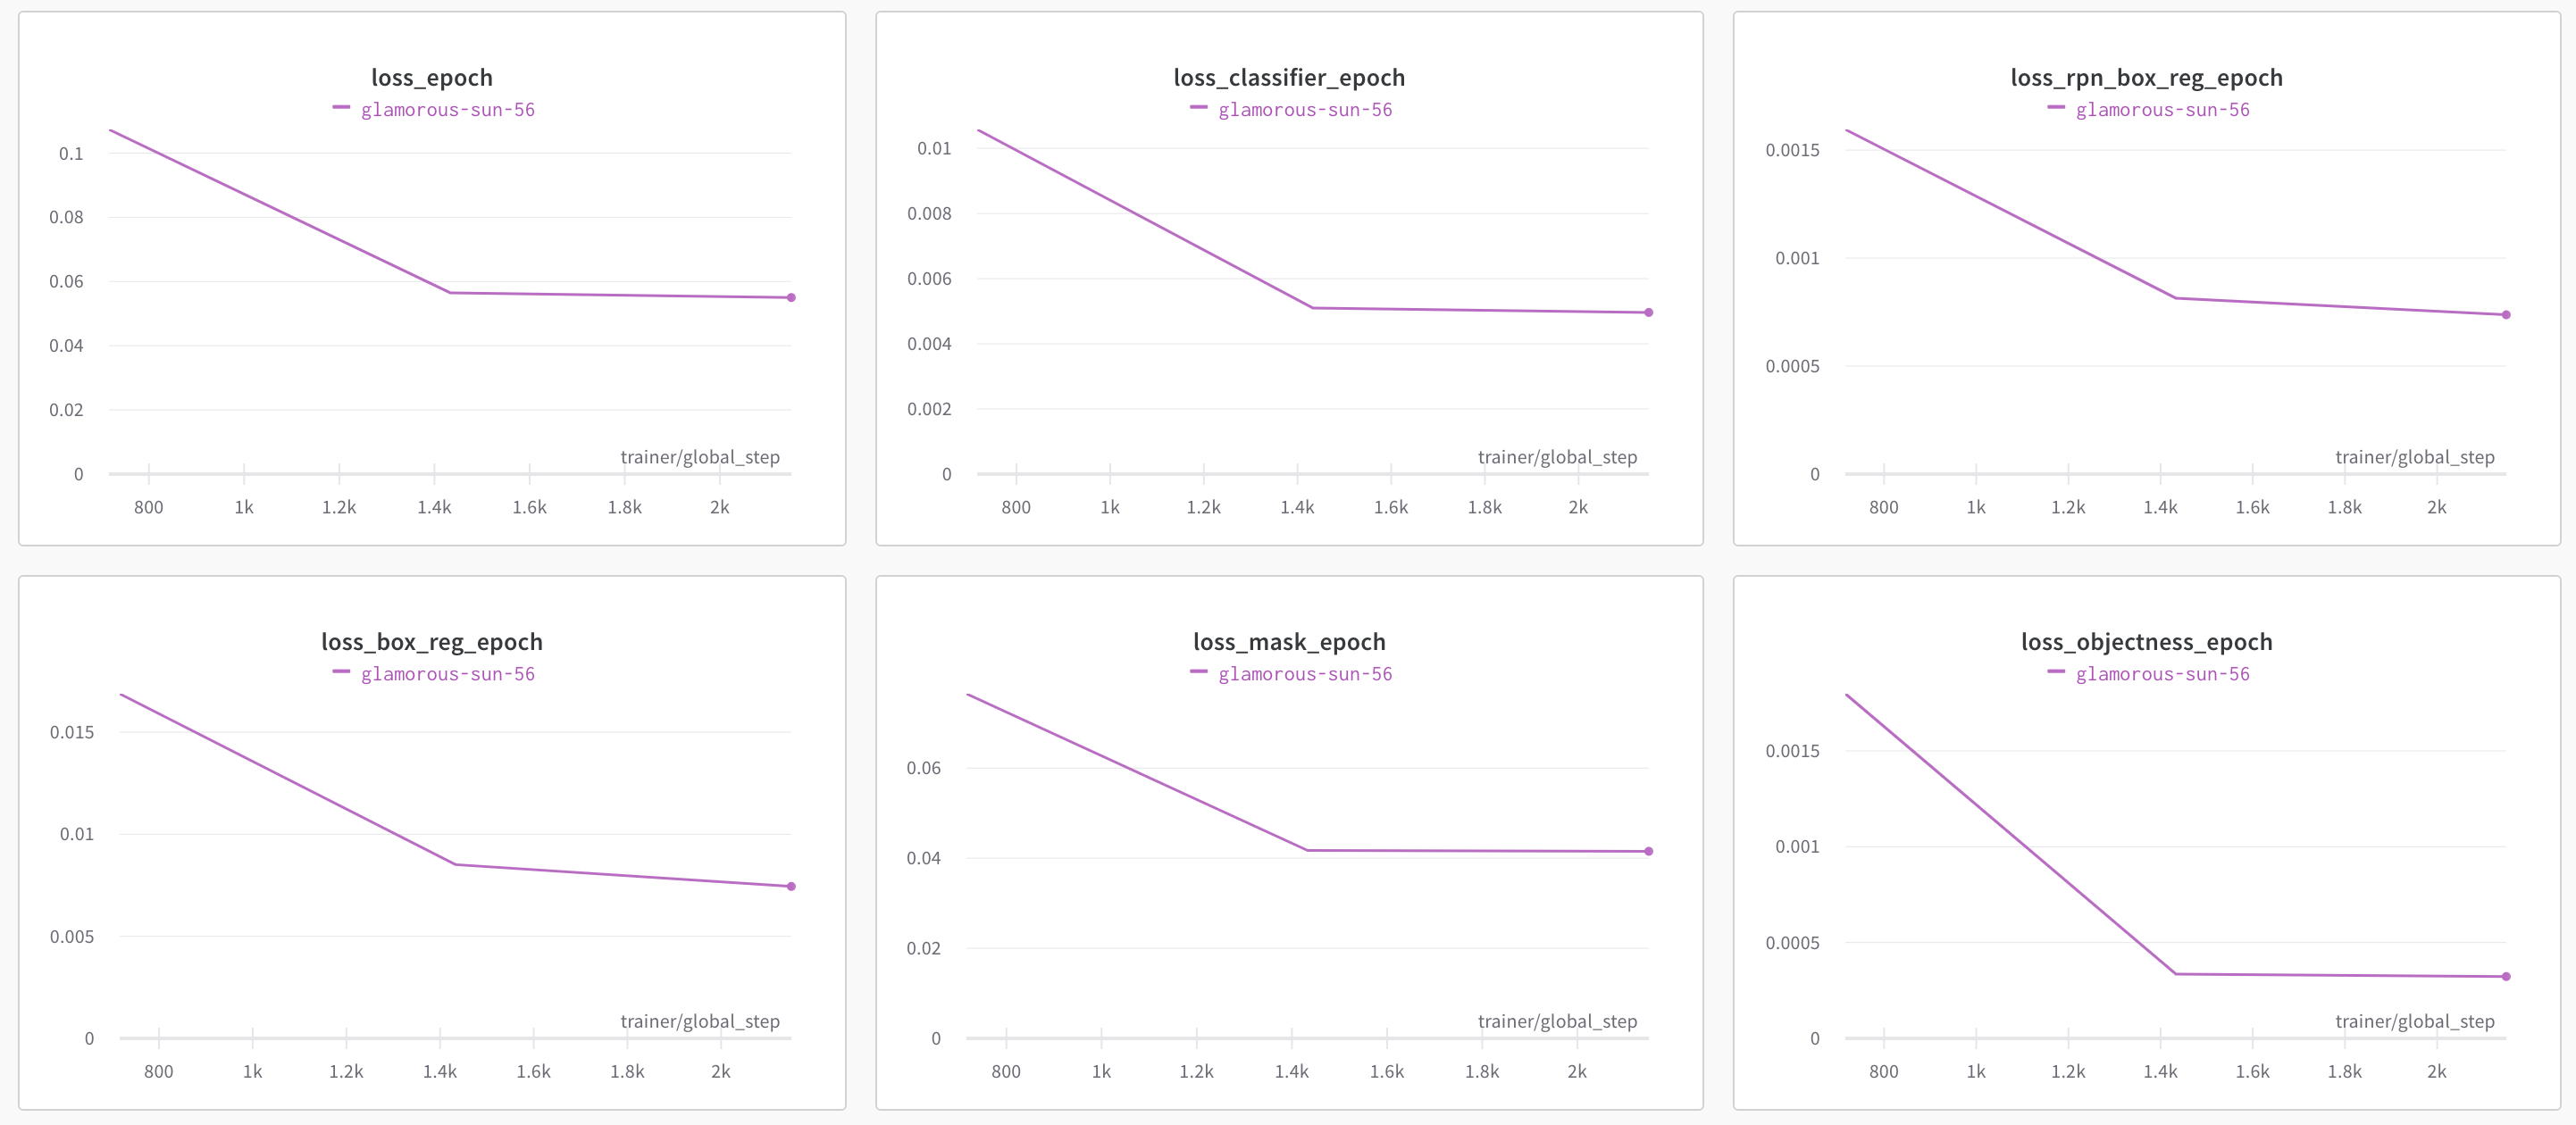

In [ ]:
# torch.save(detector, '/content/drive/MyDrive/MIPT/ocr/course_ocr/task1/detector_3.ckpt')
detector = torch.load('/content/drive/MyDrive/MIPT/ocr/course_ocr/task1/detector_3.ckpt').to(device)
detector.eval()

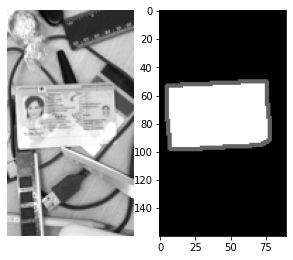

0.9558241834818593


In [94]:
with torch.no_grad():
    key, imgs, targets, quad = test_dataset[0]
    outputs = detector(imgs.unsqueeze(0).to(device))

if len(outputs[0]['masks']):
    mask = (outputs[0]['masks'][0].squeeze(0).detach().cpu().numpy() * 255).astype('uint8')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 12))
    ax1.imshow(imgs[0].detach().cpu().numpy(), cmap='gray')
    ax1.axis('off')

    _, mask = cv2.threshold(mask, 120, 255, cv2.THRESH_BINARY)
    cnts, _ = cv2.findContours(mask.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    c = max(cnts, key=cv2.contourArea)
    cv2.drawContours(mask, [c], 0, (100,100,100), 2)
    ax2.imshow(mask, cmap='gray')
    plt.show()

    corners = list(map(lambda x: [x[0][0] / 90, x[0][1] / 160], c))
    print(iou_relative_quads(corners, quad))

In [95]:
def get_border(mask):
    mask = (mask * 255).astype('uint8')
    _, mask = cv2.threshold(mask, 120, 255, cv2.THRESH_BINARY)
    cnts, _ = cv2.findContours(mask.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    c = max(cnts, key=cv2.contourArea)
    border = list(map(lambda x: [x[0][0] / 90, x[0][1] / 160], c))
    return border

### Результаты только моей модели

In [104]:
my_results_dict = dict()

for i in tqdm(range(len(test_dataset))):
    key, img, target, quad = test_dataset[i]
    with torch.no_grad():
        output = detector(img.unsqueeze(0).to(device))
        if len(output[0]['masks']) > 0:
            corners = get_border(output[0]['masks'][0].squeeze(0).detach().cpu().numpy())
            my_results_dict[key] = corners

  0%|          | 0/4250 [00:00<?, ?it/s]

In [109]:
dump_results_dict(my_results_dict, Path() / 'pred.json')
acc = measure_crop_accuracy(
    Path() / 'pred.json',
    Path() / 'gt.json'
)
print("Точность кропа: {:1.4f}".format(acc))

Точность кропа: 0.7826


## Classic CV baseline

In [11]:
class SimpleBaselineCrop:
    """
    Baseline на основе поиска и сопоставления ключевых точек на шаблоне(ref) и запросе(query)
    Алгоритм:
        0. Найти ключевые точки(КТ) на ref
        1. Найти ключевые точки(КТ) на query
        2. Сопоставить КТ query и ref друг-другу
        3. На основе сопоставления найти гомографию из ref в query
        4. Отобразить 4 угла изображения ref в query - это искомый четырехугольник кропа
    """
    def __init__(self, ref_image):
        self.ref_image = ref_image
        
        # 0. Найти ключевые точки(КТ) на ref
        self.ref_kpts, self.ref_fts = self.compute_kps(
            self.ref_image
        )

    def compute_kps(self, img, response_quantile=0.25):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sift = cv2.xfeatures2d.SIFT_create()
        kp = sift.detect(gray, None)
        # фильтруем 25% неуверенных точек
        q_val = np.quantile(list(k.response for k in kp), response_quantile)
        kp = [k for k in kp if k.response > q_val]
        
        kp, features = sift.compute(gray, kp)
        return kp, features 
    
    def find_qr_homography(self, kp_q, ft_q, kp_r, ft_r, ratio=0.75):
        # 2. Сопоставить КТ query и ref друг-другу
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(ft_q, ft_r, k=2)
        good = []

        # Дополнителный опциональный шаг - фильтрация Lowe, Lowe ratio-test:
        # Пусть есть лучший матч1 (query-kp, ref-kp)
        # Если есть другой возможный матч2 (query-kp, ref-kp2), и их качество
        # (т.е. расстояние в пространстве features) маленькое,
        # то нельзя быть уверенном, что матч1 - надежный, и проще его выбросить
        for m,n in matches:
            if m.distance <  ratio * n.distance:
                good.append([m])
                
        ptsA = np.zeros((len(good), 2), dtype="float")
        ptsB = np.zeros((len(good), 2), dtype="float")

        for (i, mlist) in enumerate(good):
            m = mlist[0]
            ptsA[i] = kp_q[m.queryIdx].pt
            ptsB[i] = kp_r[m.trainIdx].pt
        # 3. На основе сопоставления найти гомографию из ref в query
        (H, mask) = cv2.findHomography(ptsB, ptsA, method=cv2.RANSAC)
        return H
              
    def compute_crop(self, ref_img, hmg):
        # 4. Отобразить 4 угла изображения ref в query - это искомый четырехугольник кропа
        h, w, _ = ref_img.shape
        h = float(h)
        w = float(w)
        points = [
            [0, 0],
            [w, 0],
            [w, h],
            [0, h],
        ]
        points_crop = []
        for p in points:
            # применяем гомографию к точке, представленной в гомогенных координатах
            vec = hmg @ np.array([p[0], p[1], 1])
            points_crop.append([vec[0]/vec[-1], vec[1]/vec[-1]])
        return np.array(points_crop)
        
    def __call__(self, query_image):
        # 1. Найти ключевые точки(КТ) на query
        kpts, fts = self.compute_kps(query_image)
        
        homography = self.find_qr_homography(
            kpts, fts, self.ref_kpts, self.ref_fts
        )
        abs_crop = self.compute_crop(self.ref_image, homography)
        h, w, _ = query_image.shape
        rel_crop = abs_crop / np.array([[w, h]])
        return rel_crop

## Results

In [110]:
results_dict = dict()

for dp in tqdm(data_packs):
    bcm = SimpleBaselineCrop(np.array(dp.template_item.image))
    for i in range(len(dp)):
        if dp[i].is_test_split():
            try:
                results_dict[dp[i].unique_key] = bcm(np.array(dp[i].image))
            except Exception as exc:
                if dp[i].unique_key in my_results_dict:
                    results_dict[dp[i].unique_key] = my_results_dict[dp[i].unique_key]

  0%|          | 0/50 [00:00<?, ?it/s]

In [111]:
dump_results_dict(results_dict, Path() / 'pred.json')
acc = measure_crop_accuracy(
    Path() / 'pred.json',
    Path() / 'gt.json'
)
print("Точность кропа: {:1.4f}".format(acc))

Точность кропа: 0.9624
